# Analysis of the Ca8452 line

In [1]:
import sys
sys.path.append('E:\solar flares\data\\2017-09-06')
print(sys.path)
import use_nessi as un


['e:\\solar flares\\data\\2023-06-09', 'c:\\Users\\Gebruiker\\Anaconda3\\python312.zip', 'c:\\Users\\Gebruiker\\Anaconda3\\DLLs', 'c:\\Users\\Gebruiker\\Anaconda3\\Lib', 'c:\\Users\\Gebruiker\\Anaconda3', '', 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages', 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages\\win32', 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\Gebruiker\\Anaconda3\\Lib\\site-packages\\setuptools\\_vendor', 'E:\\solar flares\\data\\2017-09-06']


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14144\1816780074.py:2: SyntaxWarning: invalid escape sequence '\s'
  sys.path.append('E:\solar flares\data\\2017-09-06')


In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
# %matplotlib inline
from astropy.io import fits as f
import sunpy
from scipy.io import readsav
import cocopy as cp
import sunpy.map
import astropy.units as u
from scipy.io import readsav as rs
from PIL import Image, ImageEnhance
import use_nessi as un
from importlib import reload
import matplotlib.animation as animation
from PIL import Image
from scipy.interpolate import interp1d
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection


# functies uittesten met CaII

the following code block is not needed anymore. 

In [3]:
reload(un)

<module 'use_nessi' from 'E:\\solar flares\\data\\2017-09-06\\use_nessi.py'>

In [5]:
# And now the running commands
openfile="nb_8542_2019-05-06T08_33_15_scans=0-170_stokes_corrected_im.fits"
header= f.getheader(un.get_file_path_fits(openfile))
header = un.add_enters(str(header), length_row=79)

print(header)
# np.savetxt('headerCaK19.txt', header)

with open('headers/headerCaIR19.txt', 'w') as file:
    file.write(header)

SIMPLE  =                    T / Written by IDL:  Mon Jan 27 12:46:23 2020     
 BITPIX  =                  -32 /                                               
 NAXIS   =                    5 / Number of data axes                           
 NAXIS1  =                 1116 / Number of positions along axis 1              
 NAXIS2  =                 1070 / Number of positions along axis 2              
 NAXIS3  =                   17 / Number of positions along axis 3              
 NAXIS4  =                    4 / Number of positions along axis 4              
 NAXIS5  =                  171 / Number of positions along axis 5              
 EXTEND  =                    T / The file has extension(s).                    
 TIMESYS = 'UTC     '           /                                               
 DATE    = '2020-01-27T22:20:07' / Creation UTC date of FITS header             
 VAR_KEYS= 'VAR-EXT-DATE-BEG;DATE-BEG,VAR-EXT-DATE-END;DATE-END,VAR-EXT-DATE-AV&
'CONTINUE  'G;DATE-AVG,VAR-EX

 [astropy.io.fits.verify]


 thus falling back to mode='denywrite', which means that the array will be read-only [astropy.io.fits.file]


the found wavelengts by solarnet where  [854.13   854.1425 854.155  854.1625 854.17   854.1775 854.185  854.1925
 854.2    854.2075 854.215  854.2225 854.23   854.2375 854.245  854.2575
 854.27  ]
(1070, 1116) (1070, 1116)
Boundary
Blue=Outside, yellow=Inside


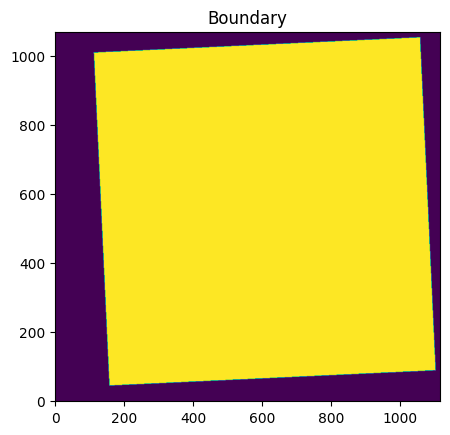

If there is still boundary left to be excluded, call self.second_boundary()
The next thing to do is to initalise the filters. Use update_filters(self, MeanSd, form='normal')
910331.0


In [6]:
reload(un)
# %matplotlib widget
CaII = un.SST_data('nb_8542_2019-05-06T08_33_15_scans=0-170_stokes_corrected_im.fits',
                   'use_solarnet','use_solarnet', name_of_line='CaIR19', thresh=[1e-7, 5e-5])


# Here the wavelengths are writen in nm in stead of angstroms
CaII._wavel =10 * CaII._wavel

# CaII.datacube
CaII.boundary
print(np.sum(CaII.boundary))

We are now cutting a bit of the boundary such that it is in the intersection of all frames and that we do not take noise frome the sides in our calculations. 
However. We have to weight the area factor a little bit to account for this.

---------------------------------

Start from here onwards

In [7]:

s = np.sum(CaII.boundary)
areafactor = s/847550 * 60**2 / (np.pi*950**2)

print(s, 'percentage of frame kept:', s/847550, 'areafactor:', areafactor) # to account for a bit of extra non excluded pixels


# CaII.datacube[70,0,:,600,600]

910331.0 percentage of frame kept: 1.0740735059878472 areafactor: 0.0013637646267018948


In [8]:
def gess_filters(n_wav):
    sd = n_wav/8
    return [[n_wav/6 - 0.5, sd], [3 * n_wav/6 - 0.5, sd], [5 * n_wav / 6 - 0.5, sd]]



[[5, 0.9], [8.0, 0.9], [11, 0.9]] 17


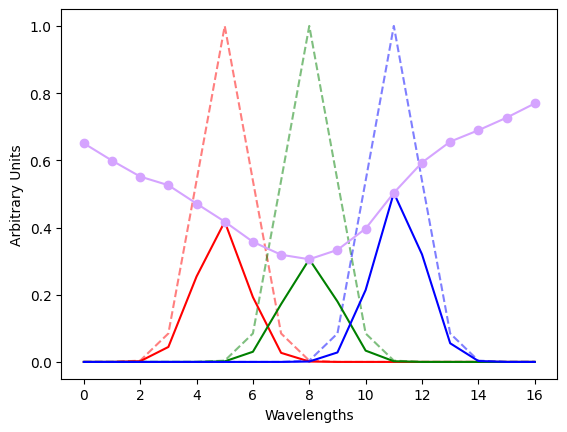

In [9]:
# %matplotlib inline
Meansd = gess_filters(len(CaII._wavel))
Meansd = [[5, 0.9], [8.0, 0.9], [11, 0.9]]
print(Meansd,len(CaII._wavel) )
CaII.update_filters(Meansd)
CaII.plot_filt(880,900)

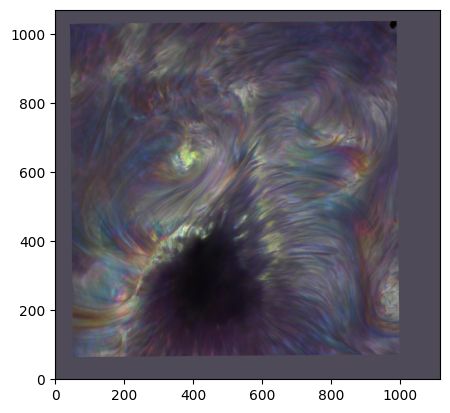

In [10]:
%matplotlib inline

CaII.ccp_frame(70,Show=False)
CaII.thresh=[1e-7,2e-5]
plt.imshow(CaII.current_ccp[:,:], origin='lower')
# plt.imshow(CaII.boundary[::-1,:], alpha=0.2)
plt.show()

#interesting pixel: (1030, 975)

In [11]:
from random import randint

# frame is an integer, the frame number
# pixels is an array listing [x,y] of the pixels of which the spectrum is to appear
def interesting_pixels(self, frame, pixels=[], rand=False, numb=5):
    if rand:
        xmax=np.shape(self.datacube)
        ymax=xmax[3]
        xmax = xmax[4]
        for i in range(numb):
            pixels.append([randint(0,xmax-1), randint(0, ymax-1)])
    else:
        numb = len(pixels)
    self.ccp_frame(frame,Show=False)
    colors=self.current_ccp

    fig, ax = plt.subplots(1)
    ax.set_title("spectral lines of some pixels: "+ self.time_of_frame(frame) )
    if len(pixels)>0:
        if hasattr(self, 'correction'):
            corr = self.correction
        else:
            corr = self._wavel*0
    for p in range(numb):
        print(f'the collor will be {colors[pixels[p][1]][pixels[p][0]]/255} but maybe better {colors[pixels[p][1]][pixels[p][0]]/255/2}')
        ax.plot(self._wavel, self.datacube[frame,0, :, pixels[p][1], pixels[p][0]]+self.scalar*corr,color=colors[pixels[p][1]][pixels[p][0]]/255/2,
                label="pixel x="+str(pixels[p][0])+" y="+str(pixels[p][1]))
    if hasattr(self, 'line_lim'):
        ax.set_xlim(self.line_lim)
    ax.set_xlabel(r"wavelength [$\rm\AA$]")
    ax.set_ylabel("intensity [units???]")
    if numb<6:
        ax.legend(fontsize=6)
    plt.show()


the collor will be [0.30980392 0.29019608 0.34509804] but maybe better [0.15490196 0.14509804 0.17254902]
the collor will be [0.41960784 0.41176471 0.45490196] but maybe better [0.20980392 0.20588235 0.22745098]
the collor will be [0.30980392 0.29019608 0.34509804] but maybe better [0.15490196 0.14509804 0.17254902]
the collor will be [0.29019608 0.25490196 0.31372549] but maybe better [0.14509804 0.12745098 0.15686275]
the collor will be [0.24313725 0.23137255 0.27843137] but maybe better [0.12156863 0.11568627 0.13921569]
the collor will be [0.22352941 0.19607843 0.28235294] but maybe better [0.11176471 0.09803922 0.14117647]
the collor will be [0.15294118 0.09019608 0.17254902] but maybe better [0.07647059 0.04509804 0.08627451]
the collor will be [0.3254902  0.32156863 0.36862745] but maybe better [0.1627451  0.16078431 0.18431373]
the collor will be [0.22745098 0.19607843 0.28235294] but maybe better [0.11372549 0.09803922 0.14117647]
the collor will be [0.3372549  0.32156863 0.41

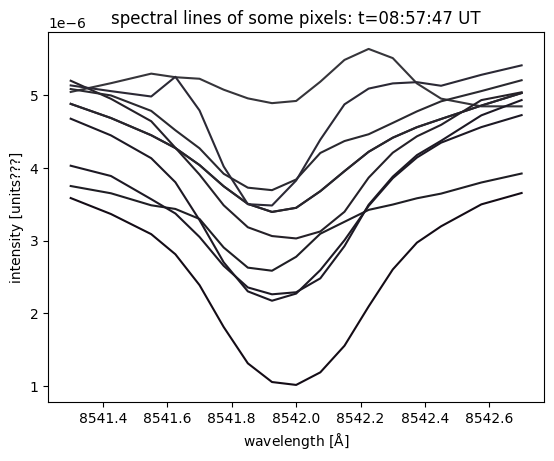

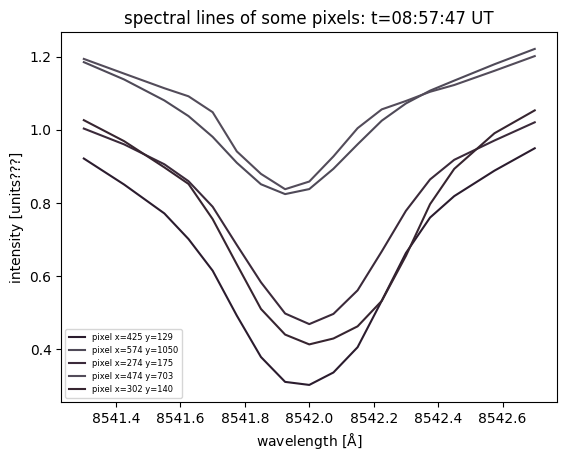

In [12]:
interesting_pixels(self= CaII, frame=70, pixels=[(1030, 975)], rand=True, numb=10)
CaII.interesting_pixels( frame=70, pixels=[(1030, 975)], rand=True, numb=5)

COCOPLOT at  t=08:33:21 UT (frame number 0 )


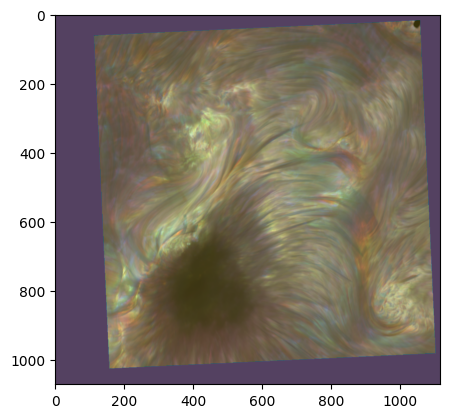

COCOPLOT at  t=08:47:19 UT (frame number 40 )


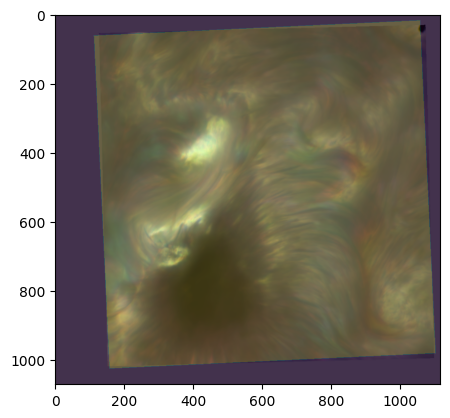

COCOPLOT at  t=09:01:16 UT (frame number 80 )


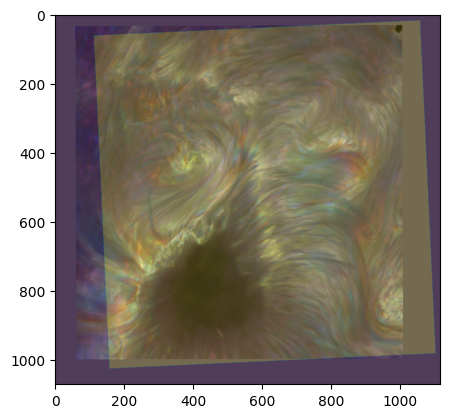

COCOPLOT at  t=09:15:13 UT (frame number 120 )


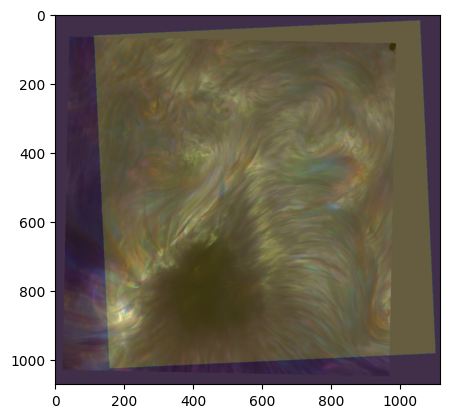

COCOPLOT at  t=09:29:11 UT (frame number 160 )


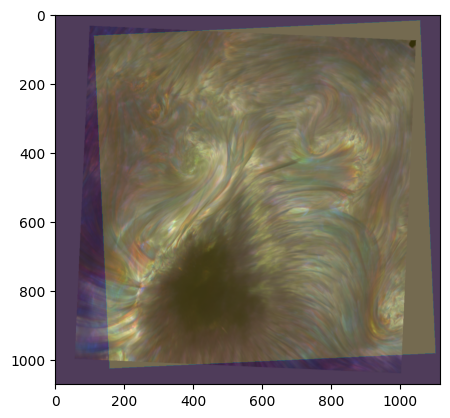

In [13]:
# Many COCOPLOTS
r = CaII._number_of_frames
for i in range(0,r,40):
    tstr = CaII.time_of_frame(i)
    print("COCOPLOT at ", tstr, "(frame number", i,")")
    CaII.ccp_frame(i,Show=False)
    plt.imshow(CaII.current_ccp[::-1,:])

    plt.imshow(CaII.boundary[::-1,:], alpha=0.2)
    plt.show()


COCOPLOT at  t=08:57:47 UT (frame number 70 )


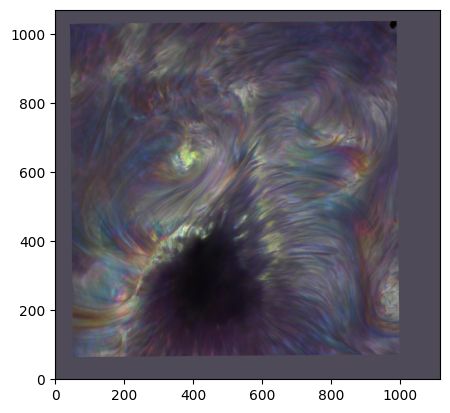

In [14]:
CaII.ccp_frame(70)
pixels=[[30,60],[631,646],[194,268],[298,323],[472,204]]
# CaII.current_ccp[0:30:5,0:60:5,:]

In [15]:
# print(pixels)
# x=[]
# frame = 70
# for frame in range(0,213,40):
#     print('frame:',frame)
#     for i in pixels:
#         x.append(CaII.datacube[frame,0,10,i[1],i[0]] - CaII.datacube[frame,0,0,i[1],i[0]])
#         print(i, x[-1])
# CaII.interesting_pixels(frame, pixels, rand=False, numb=30)
# mx = np.mean(x)
# correction = - mx * (CaII._wavel - CaII._wavel[0])
# print(CaII._wavel, correction)

# frame = 70

# print(frame)
# colors = CaII.ccp_frame(frame,Show=False)

# fig, ax = plt.subplots(1)
# ax.set_title("spectral lines of some pixels: "+ CaII.time_of_frame(frame) )
# for p in range(len(pixels)):
#     ax.plot(CaII._wavel, CaII.datacube[frame,0, :, pixels[p][1], pixels[p][0]] + correction,
#             label="pixel x="+str(pixels[p][0])+" y="+str(pixels[p][1]))
# ax.set_xlabel(r"wavelength [$\rm\AA$]")
# ax.set_ylabel("intensity [units???]")
# ax.legend(fontsize=6)
# plt.show()

In [16]:
print('1',end='\rt')
print('10 ',end='')
print('\r\r\r11 ',end='')
j=12
s = ''
for i in range(len(str(j))+1):
    s += '\r'
print(s, end=str(j))

12  

In [17]:
CaII.calculate__FOV_spect_over_time()

# try :
#     FOV_spectrum = np.load('FOV_spectrum_CaII.npy')
# except:
#     # time_av_spectrum = np.array([Ha.frame_integrated_spect(frame)/Ha.scalar for frame in range(213)])
#     FOV_spectrum=[]
#     for frame in range(np.shape(CaII.datacube)[0]):
#         s=''
#         for i in range(len(str(frame))+1):
#             s += '\r'
#         print(s, end=str(frame))
#         FOV_spectrum.append(CaII.frame_integrated_spect(frame)/CaII.scalar)

#     FOV_spectrum = np.array(FOV_spectrum)
#     np.save('FOV_spectrum_CaII.npy', FOV_spectrum)
# np.shape(FOV_spectrum), CaII.scalar

Make sure the following correction is added only once! However adding it a second time should not differ it.

In [18]:
# def add_correction(CaII, FOV_spectrum, theoretical_difference):
#     if hasattr(CaII, 'correction'):
#         print('the correction has already been done ')
#         return FOV_spectrum, CaII.correction

#     mean_difference_observation = np.mean(FOV_spectrum[:,-1]-FOV_spectrum[:,0])
#     print(mean_difference_observation, theoretical_difference)

#     correction = -(mean_difference_observation - theoretical_difference) * (CaII._wavel - CaII._wavel[0])

#     FOV_spectrum = FOV_spectrum + correction
#     CaII.correction = correction
#     return FOV_spectrum, correction

FOV_spectrum, correction = CaII.add_correction(theoretical_difference=0.03497400310369425)



In [19]:
print(correction)

[0.         0.00101395 0.00202791 0.00263628 0.00324465 0.00385302
 0.00446139 0.00506977 0.00567814 0.00628651 0.00689488 0.00750325
 0.00811163 0.00872    0.00932837 0.01034232 0.01135628]


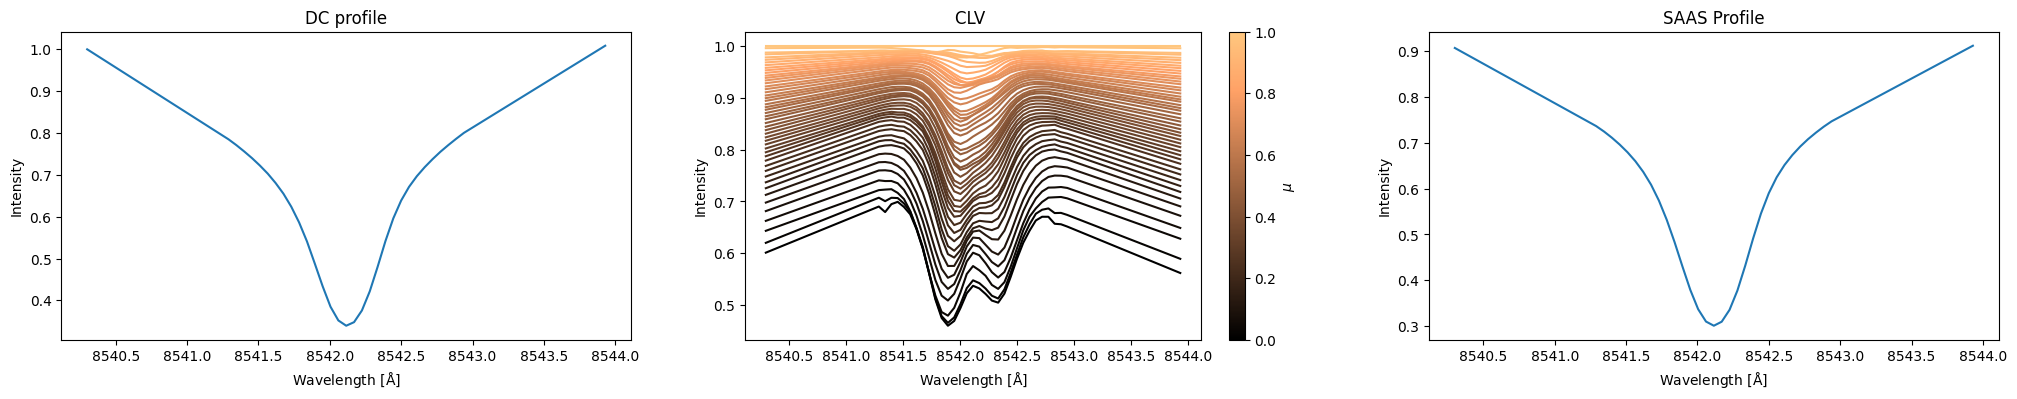

In [20]:
import use_nessi3 as un3
theor_CaII = un3.linestudier('8542_clv.fits', nr=101)


## Finding $\mu$

(171, 4, 17, 1070, 1116)
The frame is centered at (-716.921986496582, 186.15625469630433)
[-749.925986496582, -683.917986496582, 154.51385469630432, 217.79865469630434]
AVERAGE MU: The average $\mu$ wheigthed over the field of view is 0.6382678277703728 for timeframe 0
succesfully saved.
The frame is centered at (-716.921986496582, 186.15625469630433)
[-749.925986496582, -683.917986496582, 154.51385469630432, 217.79865469630434]
AVERAGE MU: The average $\mu$ wheigthed over the field of view is 0.6382678277703728 for timeframe 170
We take average mu to be  0.6382678277703728
Mu also set to the theoretic nessi line.


(0.6382678277703728, array([18], dtype=int64))

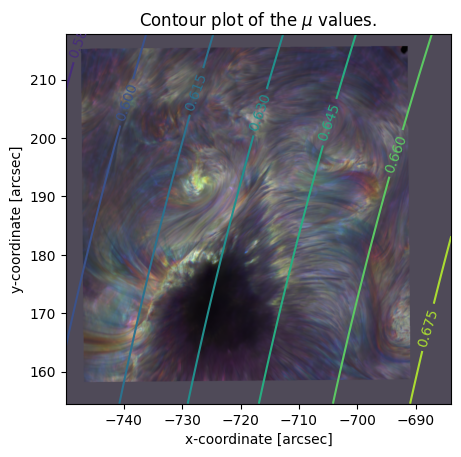

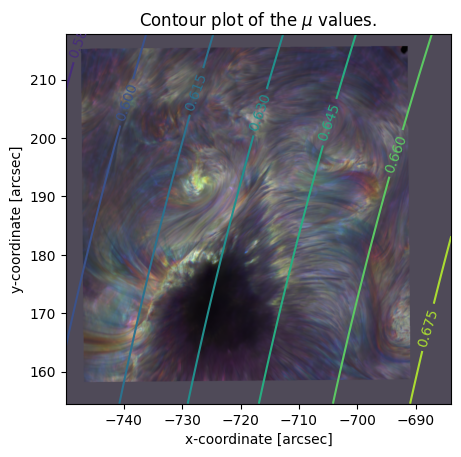

In [21]:
print(np.shape(CaII.datacube))
mu = CaII.set_mu(theor_line=theor_CaII, number_of_last_frame=170)
x = np.abs(theor_CaII.sst_mu-mu)
index_mu = np.where(x == np.min(x))[0]
mu, index_mu

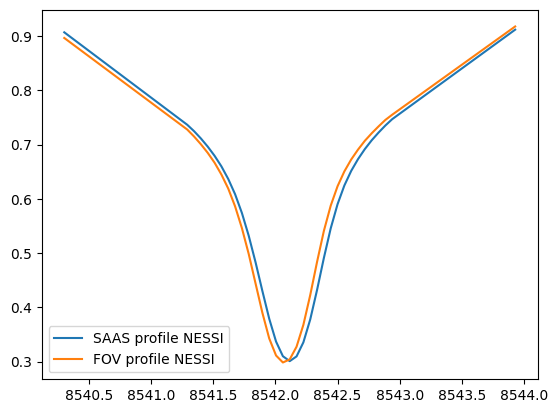

In [22]:
theor_CaII.set_fov( CaII.xx, CaII.yy, CaII.boundary, sr=959.63)

When we were scaling the width by 1.3:

![image.png](attachment:image.png)

## Finding a suitable quiet sun patch

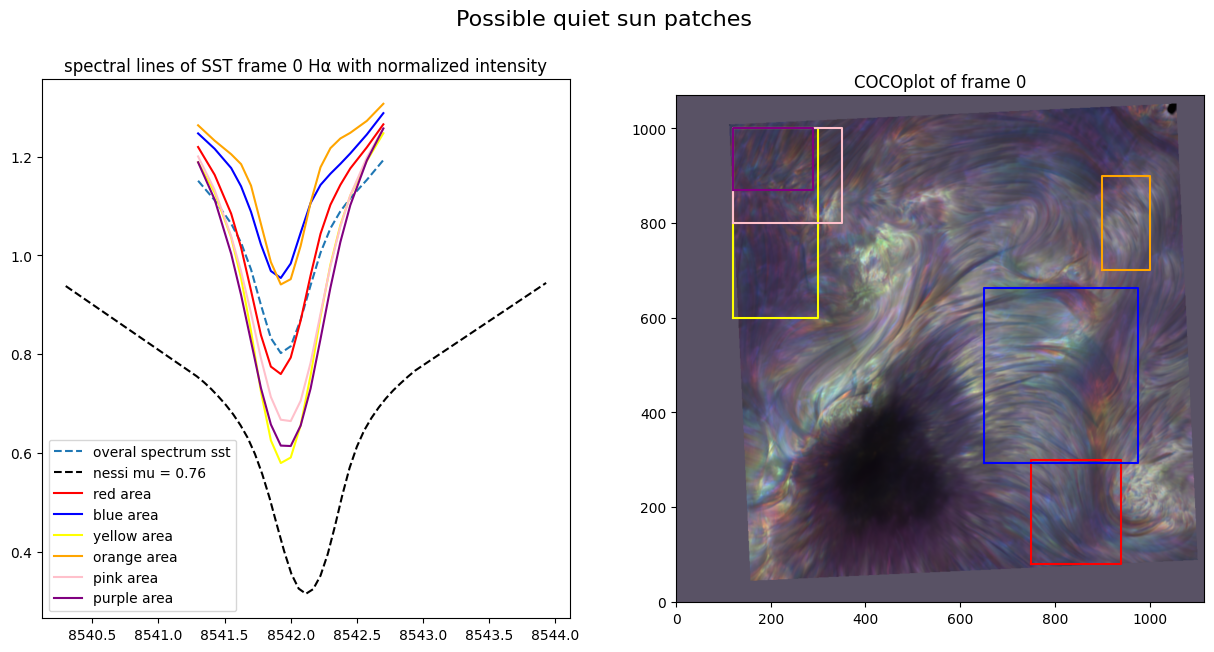

In [23]:
# %matplotlib widget
# %matplotlib inline
frame = 0

X = [[(750,940), (80,300)], [(650,975), (294,662)],[(120,300), (600,1000)], [(900, 1000), (700, 900)], [(120,350), (800,1000)] 
     , [(120,290), (870,1000)]]

CaII.possible_quiet_sun_patches(frame, theor_line = theor_CaII, X=X)

In [24]:
# the chosen quiet sun patch is 
color_wanted_patch = "yellow"

# choose from
colors=['red', 'blue', 'yellow', 'orange', 'pink', 'purple', 'limegreen', 'darkgreen', 'gray']

the edges of the patch are denoted by the xlim: (120, 300) and ylim: (600, 1000)


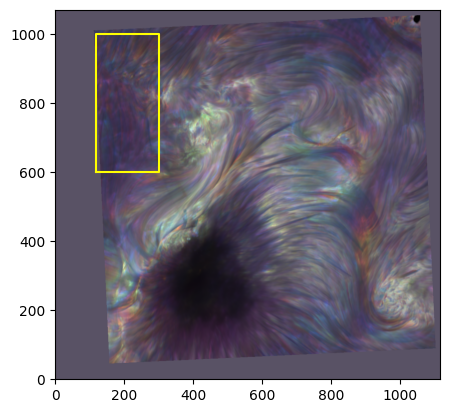

The quiet sun is pick at x (-737.5235864965821, 201.84425469630432) with average              mu 0.6042267418326498


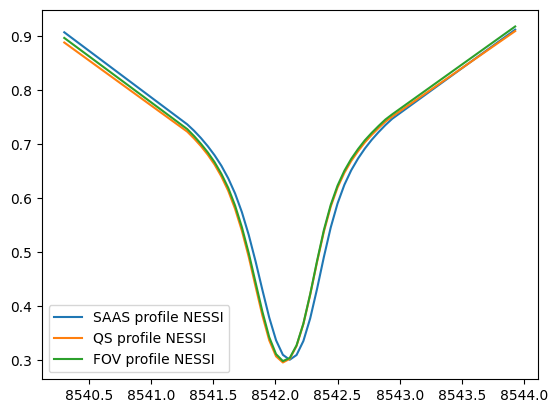

In [25]:
ind = int(colors.index(color_wanted_patch))

xlim, ylim = X[ind]
print('the edges of the patch are denoted by the xlim:', xlim, 'and ylim:', ylim)
CaII.set_quiet_sun(frame, xlim, ylim, show=False, color=color_wanted_patch)
theor_CaII.set_quiet_sun(xlim=xlim, ylim=ylim)


[8541.3   8541.425 8541.55  8541.625 8541.7   8541.775 8541.85  8541.925
 8542.    8542.075 8542.15  8542.225 8542.3   8542.375 8542.45  8542.575
 8542.7  ] [1.18859696 1.12731526 1.03631419 0.95406925 0.8467704  0.72430829
 0.62565376 0.57976265 0.59089646 0.65613893 0.75687908 0.87590012
 0.98156936 1.06128742 1.12113032 1.19118457 1.24732767] [0.720741   0.68908356 0.64600013 0.61038157 0.5616201  0.49988492
 0.42654066 0.35753344 0.30969457 0.297556   0.31770056 0.36707736
 0.44336103 0.52274868 0.58748874 0.65491898 0.69730701]
[-0.11487795  1.57543131]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 81332144.16380113
        x: [-1.131e-01  1.754e+00]
      nit: 10
      jac: [ 3.600e+01  1.300e+01]
 hess_inv: [[ 1.322e-11 -6.641e-12]
            [-6.641e-12  5.447e-12]]
     nfev: 66
     njev: 22


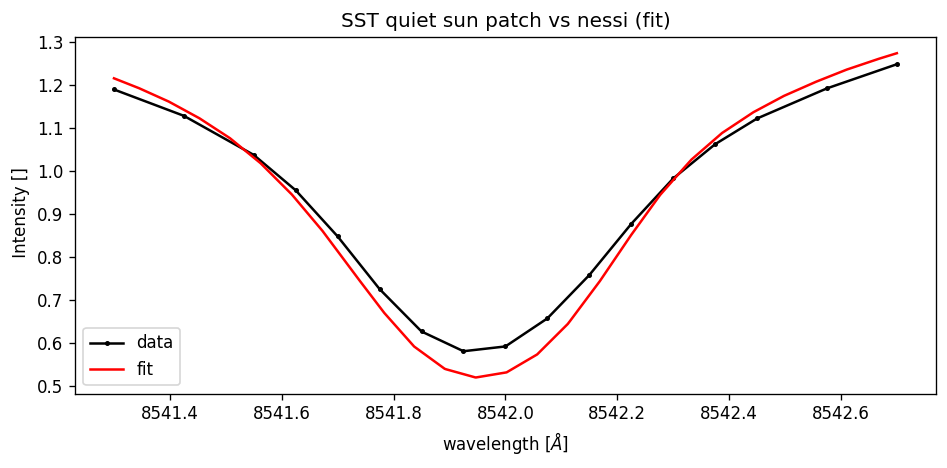

de p-waarde is  0.0 
Chi^2 reduced= 5422142.944253409 
aantal vrijheidgraden= 15 
chi^2= 81332144.16380113
we behouden de fit tot op een betrouwbaarheidsniveau van  0.0 
Oftewel verwerp als p-waarde <lpha-niveau 


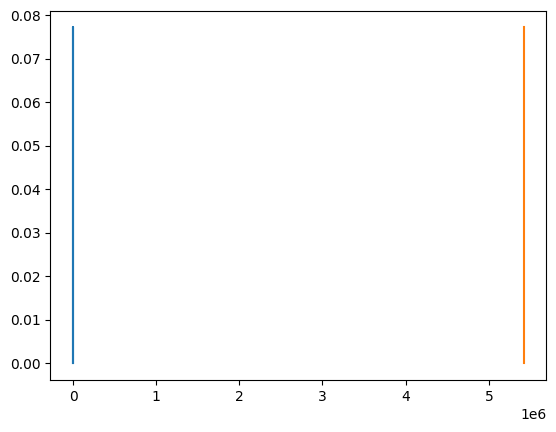

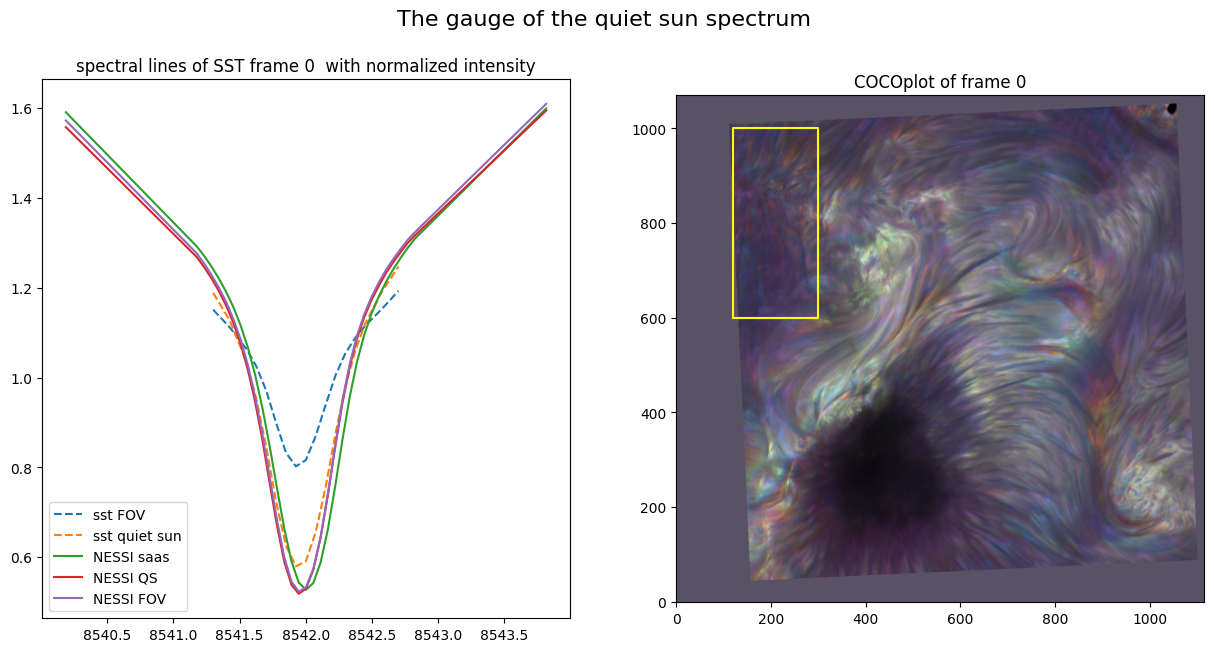

In [26]:
reload(un)
un3.fit_qs_to_NESSI(theor_CaII, CaII)

# saving Important small files for further analysis
We want the following:

* FOV_spectrum
* quiet_sun spectrum (nessi of qs)
* Full disk profile

The peak occurs at frame [34] at time t=['08:45:13 UT.
The areafactor for THIS flare is 0.0011027707545678439 compared to 60**2/np.pi/959.63**2 = 0.0012443569999152702.        
However normaly this should be alike and since the gauge is bij the Quiet sun, the conversion should be oké.        
Percentage: 88.62%.


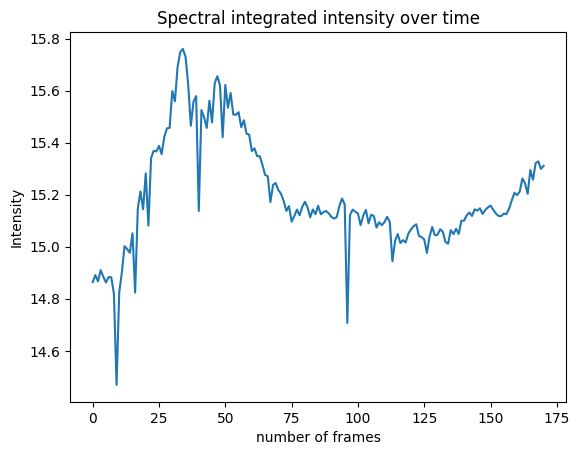

In [27]:
un.save_for_further_analysis(CaII, theor_CaII)


# Movie Making

frame: 0, 08:33:21.652515, total number of frames: 171 


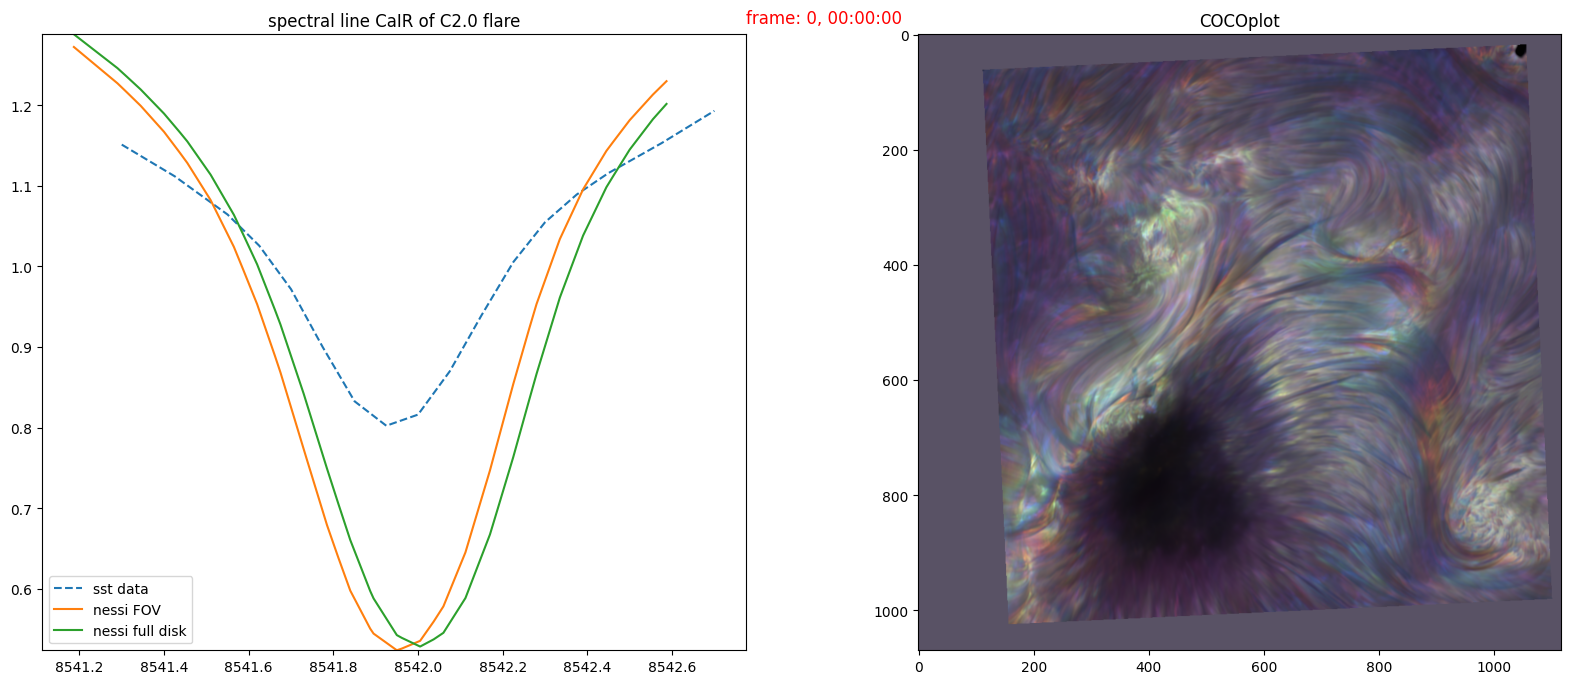

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 We are exiting this kernel


NameError: name 'exit' is not defined

In [28]:
# fill in here all arguments
theor_line = theor_CaII
sst_data = CaII
name_of_flare = "C2.0"
name_of_line = "CaIR"

un.Movie_making(theor_line, sst_data, name_of_flare, name_of_line)

In [29]:
exit()

: 